LinearSVM CV F1: 0.975 ± 0.000
DecisionTree CV F1: 0.984 ± 0.000
Saved plot to /content/outputs/q5_test_comparison.png


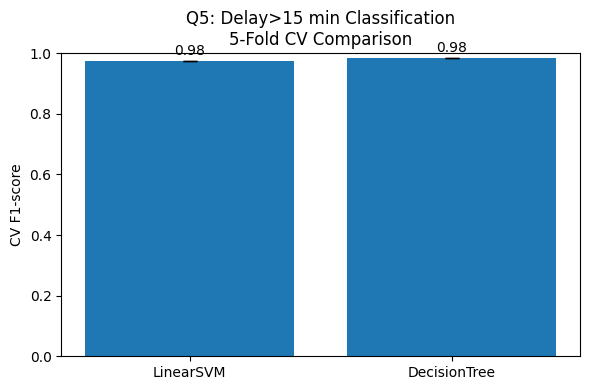

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

#  Setup paths
base = Path.cwd()
out = base / "outputs"
out.mkdir(exist_ok=True)

#  Load & parse
df = pd.read_csv(
    base / "airline_2m.csv",
    encoding="latin1",
    parse_dates=["FlightDate"],
    low_memory=False
)

#  Drop diversion and empty columns
df.drop(columns=[c for c in df if c.startswith("Div")], inplace=True)
empty = [c for c in df if df[c].notna().sum() == 0]
df.drop(columns=empty, inplace=True)

# Group by flight_key for count feature
df["flight_key"] = (
        df["Reporting_Airline"] + "_" +
        df["Origin"] + "_" +
        df["Dest"] + "_" +
        df["CRSDepTime"].astype(str)
)
df["flight_count"] = df.groupby("flight_key")["flight_key"].transform("count")

#  Create delay flag & drop raw columns
df["delay15"] = (df["ArrDelayMinutes"] > 15).astype(int)
df.drop(columns=[
    "FlightDate","ArrTime","DepTime",
    "ArrDelay","DepDelay",
    "ArrDelayMinutes","DepDelayMinutes",
    "CRSArrTime","CRSDepTime",
    "flight_key"
], inplace=True)

#  Features & target
X = df.drop(columns=["delay15"])
y = df["delay15"]

#  Preprocessing
num_cols = X.select_dtypes(include="number").columns.tolist()
cat_cols = X.select_dtypes(include="object").columns.tolist()
pre = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
])

#  Define models
models = {
    "LinearSVM": Pipeline([
        ("pre", pre),
        ("scale", StandardScaler(with_mean=False)),
        ("clf", LinearSVC(max_iter=5000, random_state=42))
    ]),
    "DecisionTree": Pipeline([
        ("pre", pre),
        ("clf", DecisionTreeClassifier(max_depth=10, random_state=42))
    ])
}

#  5-fold CV
means, stds = {}, {}
for name, pipe in models.items():
    scores = cross_val_score(pipe, X, y, cv=5, scoring="f1", n_jobs=1)
    means[name] = scores.mean()
    stds[name] = scores.std()
    print(f"{name} CV F1: {means[name]:.3f} ± {stds[name]:.3f}")

#  Plot results
names = list(models.keys())
x = np.arange(len(names))
y_vals = [means[n] for n in names]
y_err = [stds[n] for n in names]

plt.figure(figsize=(6,4))
plt.bar(x, y_vals, yerr=y_err, capsize=5)
plt.xticks(x, names)
plt.ylim(0,1)
plt.ylabel("CV F1-score")
plt.title("Q5: Delay>15 min Classification\n5-Fold CV Comparison")
for i, v in enumerate(y_vals):
    plt.text(i, v+0.02, f"{v:.2f}", ha="center")
plt.tight_layout()
plt.savefig(out / "q5_test_comparison.png")
print("Saved plot to", out / "q5_test_comparison.png")